# Agrupamento de Leis Brasileiras usando Doc2Vec e K-Means

## Importando as bibliotecas

In [2]:
# Instalando dependências
%pip install gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/14/34/f1e056feda95330f7d8beef6771e3441ce0e8e2d1f55bf754b0b0594b234/gensim-4.3.2-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
  Obtaining dependency information for smart-open>=1.8.1 from https://files.pythonhosted.org/packages/fc/d9/d97f1db64b09278aba64e8c81b5d322d436132df5741c518f3823824fae0/smart_open-6.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 12.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Carregando e Preparando os Dados

In [6]:
# Carregando os dados
df = pd.read_csv("./data/Leis de Sorocaba (Clean).csv")

# Preenchendo os valores nulos com uma string vazia:
df['summary'] = df['summary'].fillna('')

# Remover termos irrelevantes:
remove_phrases = ['dispor sobre', 'dar outro providência', 'dar outro providencia']
remove_phrases_regex = '|'.join(remove_phrases)
df['summary'] = df['summary'].str.replace(remove_phrases_regex, ' ', regex=True).str.strip()

texts = df['summary'].tolist()

In [7]:
tokenized_texts = [text.split() for text in texts]

## Preparação para o Doc2Vec

Para treinar um modelo Doc2Vec, precisamos etiquetar cada documento. O Gensim tem uma estrutura chamada TaggedDocument para isso.

In [8]:
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_texts)]

## Construindo o Modelo Doc2Vec

Aqui, construímos e treinamos o nosso modelo Doc2Vec. Escolhemos os parâmetros que definem o tamanho do vetor de embedding, a janela de contexto, e outros. O treinamento deste modelo irá resultar em um embedding ou vetor para cada documento no nosso conjunto de dados.


In [9]:
model_d2v = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=100)
model_d2v.build_vocab(tagged_data)
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

## Convertendo Textos em Vetores

Usando o modelo treinado, podemos agora converter cada documento em seu respectivo vetor. Estes vetores capturam a essência ou o significado do documento, e são essenciais para a próxima etapa de agrupamento.


In [13]:
texts_vecs = np.array([model_d2v.dv[str(i)] for i in range(len(tokenized_texts))])

## Agrupamento com K-Means

Agora que temos vetores representando cada documento, podemos usar um algoritmo de agrupamento para agrupar documentos semelhantes. Neste caso, estamos usando o K-Means, um popular algoritmo de agrupamento. O resultado será uma etiqueta de cluster para cada documento.

In [16]:
n_clusters = 11  # Substitua pelo número de clusters que você deseja
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(texts_vecs)

df['cluster'] = clusters

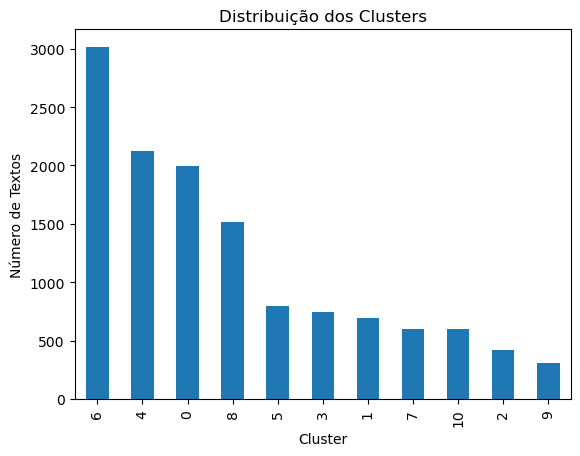

In [17]:
# Visualizando a distribuição dos clusters
df['cluster'].value_counts().plot(kind='bar')
plt.title('Distribuição dos Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de Textos')
plt.show()

In [18]:
for i in range(n_clusters):
    print(f"Cluster {i}:\n")
    print(df[df['cluster'] == i]['summary'].head(5))
    print("\n" + "="*50 + "\n")

Cluster 0:

0          denominação José antonio pascoto via público
3     denominação Desirre Ferraz Cardoso via público...
24    autorizar poder executivo instituir programa t...
27    denominação raimundo conceição Oliveira claro ...
28    denominação Benedito Pereira gomes via público...
Name: summary, dtype: object


Cluster 1:

6     instituir patrimônio cultural imaterial cidade...
7     instituir inserir calendário oficial município...
9     instituir plataforma cur canal unificar remédi...
12    instituir patrimônio cultural material cidade ...
14    emplacamento rua organização numeração imóvel ...
Name: summary, dtype: object


Cluster 2:

10    obrigatoriedade empresa concessionária fornece...
53    autorizar município sorocaba reparar dano patr...
60    priorizar atendimento diabético realização exa...
90    instituir plano Municipal combate droga municí...
93    informativo indicação horário itinerário trans...
Name: summary, dtype: object


Cluster 3:

36     declarar uti

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

def top_terms_per_cluster_d2v(model, documents, clusters, n_terms=10):
    # Calcula o vetor médio para cada cluster
    cluster_means = {}
    for cluster in set(clusters):
        docs_in_cluster = [model.infer_vector(doc) for i, doc in enumerate(documents) if clusters[i] == cluster]
        cluster_means[cluster] = np.mean(docs_in_cluster, axis=0)

    # Para cada cluster, encontre os termos mais próximos do vetor médio
    for cluster, vec in cluster_means.items():
        print(f'\nCluster {cluster}')

        similarities = []

        for doc in documents:
            sim = cosine_similarity([model.infer_vector(doc)], [vec])[0][0]
            similarities.append((doc, sim))

        # Ordena os documentos por similaridade e pega os top n_terms
        sorted_docs = sorted(similarities, key=lambda x: x[1], reverse=True)[:n_terms]

        # Conta os termos mais frequentes dos documentos mais similares
        term_counts = Counter()
        for doc, _ in sorted_docs:
            term_counts.update(doc)

        # Exibe os termos mais frequentes
        print(', '.join([term for term, _ in term_counts.most_common(n_terms)]))

top_terms_per_cluster_d2v(model_d2v, tokenized_texts, clusters)


Cluster 0
concessão, mensal, entidade, mencionar, vencimento, beneficente, caixa, subvenção, aumento, auxílio

Cluster 1
município, Sorocaba, aprovar, orçamento, urbano, sobre, imóvel, delimitação, perímetro, séde

Cluster 2
concessão, reajuste, vencimento, prorrogar, prazo, cumprimento, encargo, conferir, fundação, dom

Cluster 3
declarar, utilidade, público, Associação, acb, criancas, Belém, sorri-sorocaba, unigoverno, yazigi

Cluster 4
denominação, via, público, cidade, Leiria, Elisabeth, isr, attilio, Farsula, toyota

Cluster 5
lei, Nº, TOKEN_DATA, alterar, redação, artigo, 1, 8642, criar, ampliar

Cluster 6
autorizar, poder, executivo, conceder, auxílio, financeiro, Pontifícia, universidade, católico, Paulo

Cluster 7
denominação, praça, cidade, público, próprio, municipal, celbenedicto, franques, abolição, logradouro

Cluster 8
autorizar, poder, executivo, conceder, auxílio, financeiro, Pontifícia, universidade, católico, Paulo

Cluster 9
concessão, reajuste, vencimento, centro,

## Visualização

Vamos usar t-SNE para reduzir a dimensionalidade dos embeddings para 2D e visualizar os clusters.

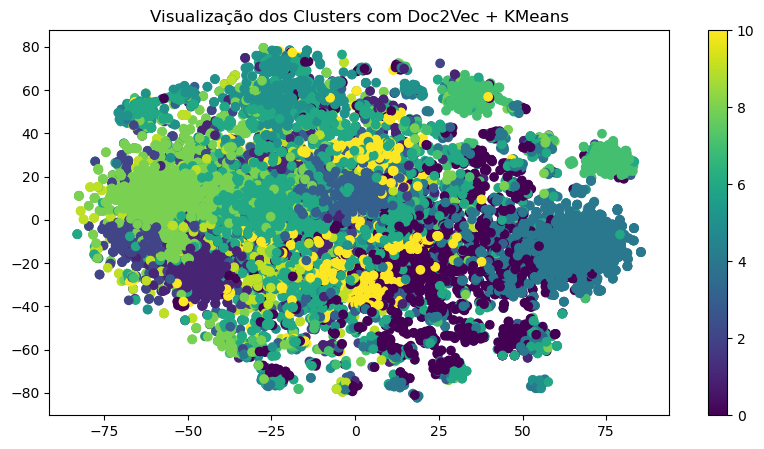

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(texts_vecs)

plt.figure(figsize=(10, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title("Visualização dos Clusters com Doc2Vec + KMeans")
plt.show()